In [1]:
import os
os.chdir('../')
import torch

from packages import *

from BranchAndBound import BranchAndBound
import pandas as pd
from sklearn.decomposition import PCA, FastICA
import copy
import json
from Utilities.Timer import Timers
import warnings
from tqdm import tqdm
import matplotlib.patches as patches

from Utilities.Plotter import plotReachability
import sys


torch.set_printoptions(precision=8)
warnings.filterwarnings("ignore")

In [2]:
from Bounding.LipschitzBound import LipschitzBounding

In [3]:
class NeuralNetwork(nn.Module):
    def __init__(self, path, A=None, B=None, c=None, activation='softplus', loadOrGenerate=True, listLayers=None):
        super().__init__()
        self.activation = activation
        if activation == 'softplus':
            activationF = nn.Softplus()
        elif activation == 'sigmoid':
            activationF = nn.Sigmoid()
        elif activation == 'tanh':
            activationF = nn.Tanh()
        else:
            activationF = nn.ReLU()

        if loadOrGenerate:
            stateDictionary = torch.load(path, map_location=torch.device("cpu"))
            layers = []
            for keyEntry in stateDictionary:
                if "weight" in keyEntry:
                    layers.append(nn.Linear(stateDictionary[keyEntry].shape[1], stateDictionary[keyEntry].shape[0]))
                    layers.append(activationF)
            layers.pop()
            self.Linear = nn.Sequential(
                *layers
            )
            self.load_state_dict(stateDictionary)

        else:
            layers = []
            for i in range(len(listLayers)-1):
                layers.append(nn.Linear(listLayers[i], listLayers[i+1]))
                torch.nn.init.xavier_uniform_(layers[-1].weight)
                layers[-1].weight.data *= 2 / torch.linalg.norm(layers[-1].weight.data, ord=2)
                layers.append(activationF,)
            layers.pop()

            self.Linear = nn.Sequential(*layers)
        
        self.isLinear = True
        self.rotation = nn.Identity()
        self.A = A
        self.B = B
        self.c = c

        if self.A is None:
            dimInp = self.Linear[0].weight.shape[1]
            dimOut = self.Linear[-1].weight.shape[0]
            if False:
                self.A = torch.zeros((dimOut, dimInp)).float()
                self.B = torch.eye(dimOut, dimOut).float()
                self.c = torch.zeros(dimOut).float()
            else:
                self.A = torch.zeros((dimInp, dimInp)).float()
                self.B = torch.ones((dimInp, dimOut)).float()
                self.c = torch.zeros(dimOut).float()


    def load(self, path):
        stateDict = torch.load(path, map_location=torch.device("cpu"))
        self.load_state_dict(stateDict)

    def setRepetition(self, repetition):
        self.repetition = repetition

    def forward(self, x):
        x = self.rotation(x)
        for i in range(self.repetition):
            x = x @ self.A.T + self.Linear(x) @ self.B.T + self.c
        return x

In [4]:
def compareSecondOrderMethods(pcaDirections, config, device, network,
                                originalNetwork, horizonForLipschitz, lowerCoordinate, upperCoordinate,
                                boundingMethod):
    
    virtualBranching = config['virtualBranching']
    numberOfVirtualBranches = config['numberOfVirtualBranches']
    maxSearchDepthLipschitzBound = config['maxSearchDepthLipschitzBound']
    normToUseLipschitz = config['normToUseLipschitz']
    useTwoNormDilation = config['useTwoNormDilation']
    useSdpForLipschitzCalculation = config['useSdpForLipschitzCalculation']
    lipschitzSdpSolverVerbose = config['lipschitzSdpSolverVerbose']

    timers = Timers(["lowerBound",
                        "lowerBound:lipschitzForwardPass", "lowerBound:lipschitzCalc",
                        "lowerBound:lipschitzSearch",
                        "lowerBound:virtualBranchPreparation", "lowerBound:virtualBranchMin",
                        "upperBound",
                        "bestBound",
                        "branch", "branch:prune", "branch:maxFind", "branch:nodeCreation",
                        "LipSDP",
                        ])


        
    lowerBoundClass = LipschitzBounding(network, device, virtualBranching, maxSearchDepthLipschitzBound,
                                                 normToUseLipschitz, useTwoNormDilation, useSdpForLipschitzCalculation,
                                                 numberOfVirtualBranches, lipschitzSdpSolverVerbose,
                                                 [],
                                                 originalNetwork=originalNetwork,
                                                 horizon=horizonForLipschitz,
                                                 boundingMethod=boundingMethod
                                                 )
    
    M1, M2, M3, M4, M5, M6, T = lowerBoundClass.compareSecondOrder(lowerCoordinate.reshape(1, -1), upperCoordinate.reshape(1, -1), pcaDirections[0], timers)
    
    return M1, M2, M3, M4, M5, M6, T[0], T[1]


def main(Method = None):
    configFolder = "Config/"
    fileName = ["RobotArmS", "DoubleIntegratorS", "quadrotorS", "MnistS" , "test"]
    fileName = fileName[2]

    configFileToLoad = configFolder + fileName + ".json"

    with open(configFileToLoad, 'r') as file:
        config = json.load(file)

    eps = config['eps']
    verboseMultiHorizon = config['verboseMultiHorizon']
    normToUseLipschitz = config['normToUseLipschitz']
    useSdpForLipschitzCalculation = config['useSdpForLipschitzCalculation']
    finalHorizon = 1
    performMultiStepSingleHorizon = config['performMultiStepSingleHorizon']
    plotProjectionsOfHigherDims = config['plotProjectionsOfHigherDims']
    onlyPcaDirections = config['onlyPcaDirections']
    pathToStateDictionary = config['pathToStateDictionary']
    fullLoop = config['fullLoop']
    try:
        initialZonotope = config['InitialZonotope']
    except:
        initialZonotope = False
    try:
        activation = config['activation']
    except:
        activation = 'relu'
    try:
        splittingMethod = config['splittingMethod']
    except:
        splittingMethod = 'length'

    if Method == None:
        boundingMethod = config['boundingMethod']
    else:
        boundingMethod = Method
    A = B = c = None
    try:
        lowerCoordinate = torch.Tensor(config['lowerCoordinate'])
        upperCoordinate = torch.Tensor(config['upperCoordinate'])
    except:
        pass


    if not verboseMultiHorizon:
        plotProjectionsOfHigherDims = False

    if finalHorizon > 1 and performMultiStepSingleHorizon and\
            (normToUseLipschitz != 2 or not useSdpForLipschitzCalculation):
        raise ValueError

    if torch.cuda.is_available():
        device = torch.device("cuda", 0)
    else:
        device = torch.device("cpu")

    if False:
        print(device)
        print(' ')
    
    lowerCoordinate = lowerCoordinate.to(device)
    upperCoordinate = upperCoordinate.to(device)

    listLayers = [[6, 32, 3],
                  [6, 32, 32, 3],
                  [6, 32, 32, 32, 3],
                  [6, 32, 32, 32, 32, 3],
                  [6, 32, 32, 32, 32, 32, 3],
                  [6, 32, 32, 32, 32, 32, 32, 3],
                  [6, 32, 32, 32, 32, 32, 32, 32, 3],
                  [6, 32, 32, 32, 32, 32, 32, 32, 32, 3],
                  [6, 32, 32, 32, 32, 32, 32, 32, 32, 32, 3],
                  [6,32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 3]]
    
    simpleHessianBoundLayer = []; simpleLocalHessianBoundLayer = []
    LipHessianBoundLayer = []; LipHessianLocalBoundLayer = []; LipSDPTimeLayer = []
    HalfHessianBoundLayer = []; HalfHessianLocalBoundLayer = []; LipLTLocalTimeLayer = []
    for listLayer in listLayers:
        simpleHessianBound = []; simpleLocalHessianBound = []
        LipHessianBound = []; LipLocalHessianBound = []; LipSDPTime = []
        HalfHessianBound = []; HalfLocalHessianBound = []; LipLTLocalTime = []
        sys.stdout.flush()
        for __ in tqdm(range(10)):
            network = NeuralNetwork(pathToStateDictionary, A, B, c, activation=activation, loadOrGenerate=False, listLayers=listLayer)
            # print(network)
            # @TODO: move this
            horizonForLipschitz = 1
            originalNetworkZonotope = None
            dimZ = lowerCoordinate.shape[0]
            dim = network.Linear[0].weight.shape[1]
            outputDim = network.Linear[-1].weight.shape[0]
            network.to(device)
            inputData = (upperCoordinate - lowerCoordinate) * torch.rand(10000, dimZ, device=device) \
                                                        + lowerCoordinate
            # startTime = time.time()
            # totalLipSDPTime = 0
            for iteration in range(finalHorizon):
                inputDataVariable = Variable(inputData, requires_grad=False)
                # @TODO: move this
                if iteration == 0:
                        networkZonotope = copy.deepcopy(network)
                else:
                        rotation =  networkZonotope.rotation
                        networkZonotope = copy.deepcopy(network)
                        networkZonotope.rotation = rotation

                originalNetworkZonotope = copy.deepcopy(networkZonotope)
                pcaDirections = torch.rand((1, dim))
                M1, M2, M3, M4, M5, M6, TLipSDP, TLipLTLocal = compareSecondOrderMethods(pcaDirections, config, device, networkZonotope,
                                                    originalNetworkZonotope, horizonForLipschitz, lowerCoordinate, upperCoordinate,
                                                    boundingMethod)
                
                # print(M1, M2, M3)
                simpleHessianBound.append(M1);simpleLocalHessianBound.append(M2)
                LipHessianBound.append(M3); LipLocalHessianBound.append(M4); LipSDPTime.append(TLipSDP)
                HalfHessianBound.append(M5[0]); HalfLocalHessianBound.append(M6[0]), LipLTLocalTime.append(TLipLTLocal)
        
        simpleHessianBoundLayer.append(torch.Tensor(simpleHessianBound))
        simpleLocalHessianBoundLayer.append(torch.Tensor(simpleLocalHessianBound))
        LipHessianBoundLayer.append(torch.Tensor(LipHessianBound))
        LipHessianLocalBoundLayer.append(torch.Tensor(LipLocalHessianBound)); LipSDPTimeLayer.append(torch.Tensor(LipSDPTime))
        HalfHessianBoundLayer.append(torch.Tensor(HalfHessianBound))
        HalfHessianLocalBoundLayer.append(torch.Tensor(HalfLocalHessianBound)), LipLTLocalTimeLayer.append(torch.Tensor(LipLTLocalTime))
        # sys.stdout.flush()
        # print("Simple Hessian Bound: ", torch.mean(torch.Tensor(simpleHessianBound)))
        # print("Lipschitz Hessian Bound: ", torch.mean(torch.Tensor(LipHessianBound)))
        # print('---')
        # sys.stdout.flush()

    simpleHessianBoundLayer = torch.vstack(simpleHessianBoundLayer)
    simpleLocalHessianBoundLayer = torch.vstack(simpleLocalHessianBoundLayer)
    LipHessianBoundLayer = torch.vstack(LipHessianBoundLayer)
    LipHessianLocalBoundLayer = torch.vstack(LipHessianLocalBoundLayer)
    HalfHessianBoundLayer = torch.vstack(HalfHessianBoundLayer)
    HalfHessianLocalBoundLayer = torch.vstack(HalfHessianLocalBoundLayer)
    return simpleHessianBoundLayer, simpleLocalHessianBoundLayer, LipHessianBoundLayer, LipHessianLocalBoundLayer,\
                    HalfHessianBoundLayer, HalfHessianLocalBoundLayer, LipSDPTimeLayer, LipLTLocalTimeLayer        

In [5]:
if __name__ == '__main__':
    for Method in ['secondOrder']:
        for i in range(1):
            simpleHessianBoundLayer, simpleLocalHessianBoundLayer, LipHessianBoundLayer, LipLocalHessianBoundLayer ,\
                HalfHessionBoundLayer, HalfLocalHessianBoundLayer, LipSDPTime, LipLTTime= main(Method)
            sys.stdout.flush()
            # print("Simple Hessian Bound: ", torch.mean(simpleHessianBoundLayer, dim=1))
            # print("Lipschitz Hessian Bound: ", torch.mean(LipHessianBoundLayer, dim=1))
            # print("Half Hessian Bound: ", torch.mean(HalfHessionBoundLayer, dim=1))
            # print("Half Local Hessian Bound: ", torch.mean(HalfLocalHessianBoundLayer, dim=1))
            sys.stdout.flush()



100%|██████████| 10/10 [06:08<00:00, 36.83s/it]

Simple Hessian Bound:  tensor([1.22237110e+01, 5.85870590e+01, 4.43998962e+02, 2.34347290e+03,
        1.42810469e+04, 7.14941250e+04, 3.91202312e+05, 1.93247438e+06,
        1.13870860e+07, 5.32608160e+07])


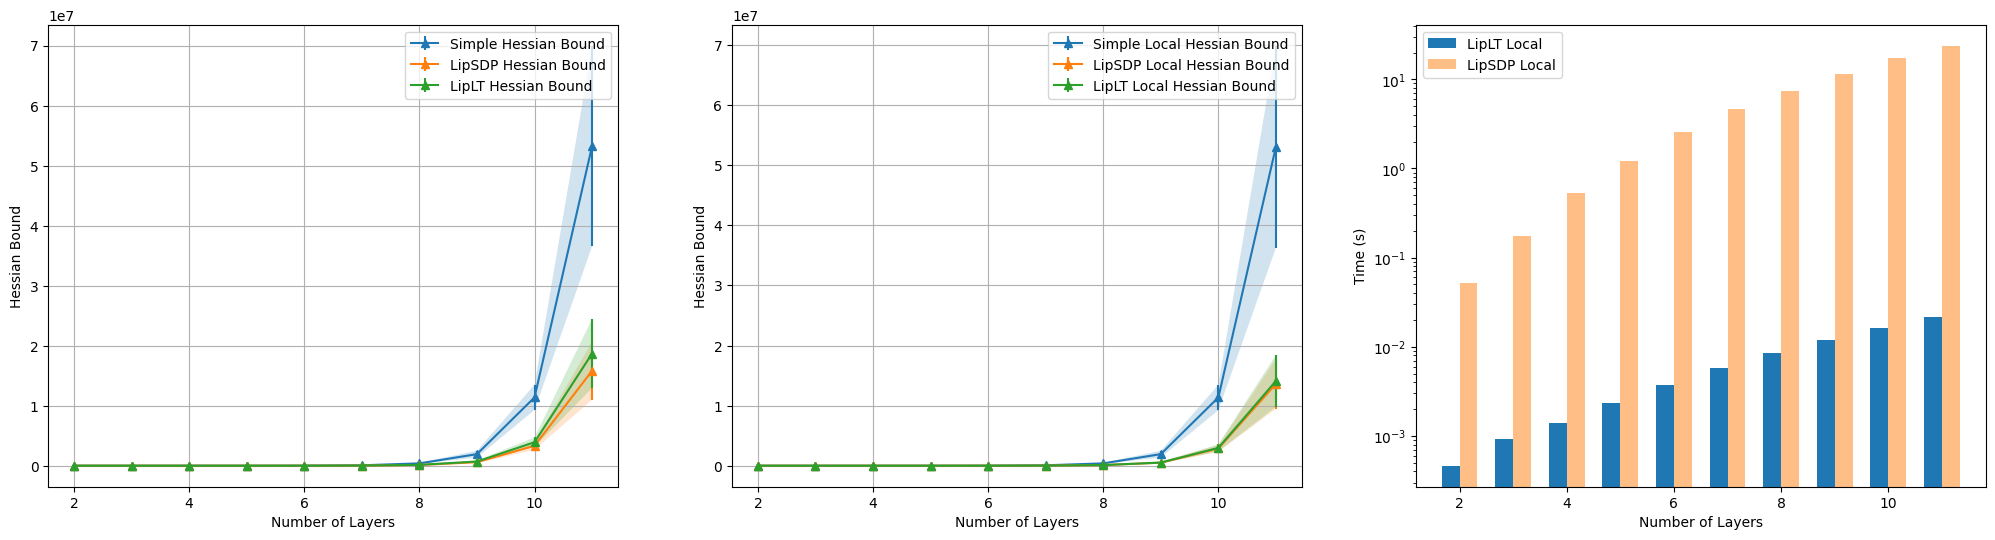

In [9]:
plt.figure(figsize=(25, 6))
plt.subplot(1, 3, 1)

plt.errorbar([i + 2 for i in range(len(simpleHessianBoundLayer[:, 0]))], torch.mean(simpleHessianBoundLayer, dim=1) ,
              torch.std(simpleHessianBoundLayer, dim=1), marker='^', label='Simple Hessian Bound')
# plt.plot([i for i in range(len(simpleHessianBoundLayer[:, 0]))], torch.mean(simpleHessianBoundLayer, dim=1), marker='^', label='Simple Hessian Bound')
plt.fill_between([i+2 for i in range(len(simpleHessianBoundLayer[:, 0]))], torch.mean(simpleHessianBoundLayer, dim=1) - torch.std(simpleHessianBoundLayer, dim=1),
                torch.mean(simpleHessianBoundLayer, dim=1) + torch.std(simpleHessianBoundLayer, dim=1), alpha=0.2)


plt.errorbar([i+2 for i in range(len(LipHessianBoundLayer[:, 0]))], torch.mean(LipHessianBoundLayer, dim=1) ,
                torch.std(LipHessianBoundLayer, dim=1), marker='^', label='LipSDP Hessian Bound')
# plt.plot([i for i in range(len(LipHessianBoundLayer[:, 0]))], torch.mean(LipHessianBoundLayer, dim=1), marker='^', label='Lipschitz Hessian Bound')
plt.fill_between([i+2 for i in range(len(LipHessianBoundLayer[:, 0]))], torch.mean(LipHessianBoundLayer, dim=1) - torch.std(LipHessianBoundLayer, dim=1),
                torch.mean(LipHessianBoundLayer, dim=1) + torch.std(LipHessianBoundLayer, dim=1), alpha=0.2)

plt.errorbar([i+2 for i in range(len(HalfHessionBoundLayer[:, 0]))], torch.mean(HalfHessionBoundLayer, dim=1) ,
                torch.std(HalfHessionBoundLayer, dim=1), marker='^', label='LipLT Hessian Bound')
# plt.plot([i for i in range(len(HalfHessionBoundLayer[:, 0]))], torch.mean(HalfHessionBoundLayer, dim=1), marker='^', label='Half Hessian Bound')
plt.fill_between([i+2 for i in range(len(HalfHessionBoundLayer[:, 0]))], torch.mean(HalfHessionBoundLayer, dim=1) - torch.std(HalfHessionBoundLayer, dim=1),
                torch.mean(HalfHessionBoundLayer, dim=1) + torch.std(HalfHessionBoundLayer, dim=1), alpha=0.2)

plt.ylabel('Hessian Bound')
plt.xlabel('Number of Layers')
plt.grid()
plt.legend()

plt.subplot(1, 3, 2)

plt.errorbar([i + 2 for i in range(len(simpleLocalHessianBoundLayer[:, 0]))], torch.mean(simpleLocalHessianBoundLayer, dim=1) ,
              torch.std(simpleLocalHessianBoundLayer, dim=1), marker='^', label='Simple Local Hessian Bound')
# plt.plot([i for i in range(len(simpleHessianBoundLayer[:, 0]))], torch.mean(simpleHessianBoundLayer, dim=1), marker='^', label='Simple Hessian Bound')
plt.fill_between([i+2 for i in range(len(simpleLocalHessianBoundLayer[:, 0]))], torch.mean(simpleLocalHessianBoundLayer, dim=1) - torch.std(simpleLocalHessianBoundLayer, dim=1),
                torch.mean(simpleLocalHessianBoundLayer, dim=1) + torch.std(simpleLocalHessianBoundLayer, dim=1), alpha=0.2)

plt.errorbar([i+2 for i in range(len(LipLocalHessianBoundLayer[:, 0]))], torch.mean(LipLocalHessianBoundLayer, dim=1) ,
                torch.std(LipLocalHessianBoundLayer, dim=1), marker='^', label='LipSDP Local Hessian Bound')
# plt.plot([i for i in range(len(LipHessianBoundLayer[:, 0]))], torch.mean(LipHessianBoundLayer, dim=1), marker='^', label='Lipschitz Hessian Bound')
plt.fill_between([i+2 for i in range(len(LipLocalHessianBoundLayer[:, 0]))], torch.mean(LipLocalHessianBoundLayer, dim=1) - torch.std(LipLocalHessianBoundLayer, dim=1),
                torch.mean(LipLocalHessianBoundLayer, dim=1) + torch.std(LipLocalHessianBoundLayer, dim=1), alpha=0.2)


plt.errorbar([i+2 for i in range(len(HalfLocalHessianBoundLayer[:, 0]))], torch.mean(HalfLocalHessianBoundLayer, dim=1) ,
                torch.std(HalfLocalHessianBoundLayer, dim=1), marker='^', label='LipLT Local Hessian Bound')
# plt.plot([i for i in range(len(HalfLocalHessianBoundLayer[:, 0]))], torch.mean(HalfLocalHessianBoundLayer, dim=1), marker='^', label='Half Local Hessian Bound')
plt.fill_between([i+2 for i in range(len(HalfLocalHessianBoundLayer[:, 0]))], torch.mean(HalfLocalHessianBoundLayer, dim=1) - torch.std(HalfLocalHessianBoundLayer, dim=1),
                torch.mean(HalfLocalHessianBoundLayer, dim=1) + torch.std(HalfLocalHessianBoundLayer, dim=1), alpha=0.2)


plt.ylabel('Hessian Bound')
plt.xlabel('Number of Layers')
plt.grid()
plt.legend()


plt.subplot(1, 3, 3)
clmnwdth = [1 for i in range(1, len(HalfLocalHessianBoundLayer) + 1)]
plt.bar(height=torch.mean(torch.vstack(LipLTTime), dim=1), x=torch.arange(2, len(HalfLocalHessianBoundLayer) + 2) - torch.Tensor(clmnwdth)/6, 
                width=torch.Tensor(clmnwdth)/3, alpha=1, label='LipLT Local')
plt.bar(height=torch.mean(torch.vstack(LipSDPTime), dim=1), x=torch.arange(2, len(HalfLocalHessianBoundLayer) + 2) + torch.Tensor(clmnwdth)/6, 
                width=torch.Tensor(clmnwdth)/3, alpha=0.5, label='LipSDP Local')



plt.ylabel('Time (s)')
plt.xlabel('Number of Layers')
plt.yscale('log')
# plt.xscale('log')
plt.legend()


plt.show()

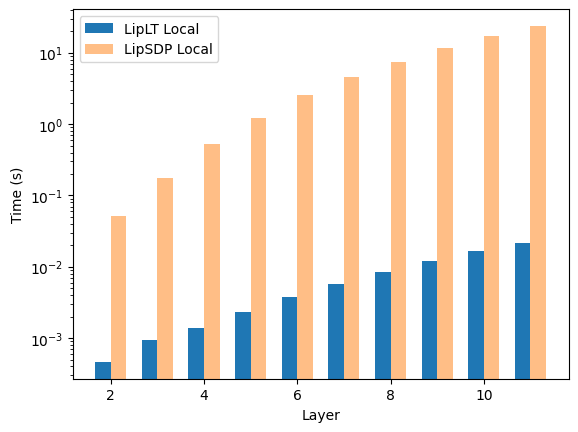

In [7]:
# # clmnwdth = [np.exp(i) / 17 for i in range(1, len(HalfLocalHessianBoundLayer) + 1)]
# clmnwdth = [2 for i in range(1, len(HalfLocalHessianBoundLayer) + 1)]

# plt.bar(height=torch.mean(torch.vstack(LipLTTime), dim=1), x=torch.mean(HalfLocalHessianBoundLayer, dim=1) - torch.Tensor(clmnwdth)/4, 
#                 width=torch.Tensor(clmnwdth)/2, alpha=1, label='LipLT Local')
# plt.bar(height=torch.mean(torch.vstack(LipSDPTime), dim=1), x=torch.mean(LipLocalHessianBoundLayer, dim=1) + torch.Tensor(clmnwdth)/4, 
#                 width=torch.Tensor(clmnwdth)/2, alpha=0.5, label='LipSDP Local')

clmnwdth = [1 for i in range(1, len(HalfLocalHessianBoundLayer) + 1)]
plt.bar(height=torch.mean(torch.vstack(LipLTTime), dim=1), x=torch.arange(2, len(HalfLocalHessianBoundLayer) + 2) - torch.Tensor(clmnwdth)/6, 
                width=torch.Tensor(clmnwdth)/3, alpha=1, label='LipLT Local')
plt.bar(height=torch.mean(torch.vstack(LipSDPTime), dim=1), x=torch.arange(2, len(HalfLocalHessianBoundLayer) + 2) + torch.Tensor(clmnwdth)/6, 
                width=torch.Tensor(clmnwdth)/3, alpha=0.5, label='LipSDP Local')



plt.ylabel('Time (s)')
plt.xlabel('Layer')
plt.yscale('log')
# plt.xscale('log')
plt.legend()

plt.show()

In [8]:
# plt.figure(figsize=(25, 6))
# plt.subplot(1, 4, 1)

# plt.errorbar([i + 2 for i in range(len(simpleHessianBoundLayer[:, 0]))], torch.mean(simpleHessianBoundLayer, dim=1) ,
#               torch.std(simpleHessianBoundLayer, dim=1), marker='^', label='Simple Hessian Bound')
# # plt.plot([i for i in range(len(simpleHessianBoundLayer[:, 0]))], torch.mean(simpleHessianBoundLayer, dim=1), marker='^', label='Simple Hessian Bound')
# plt.fill_between([i+2 for i in range(len(simpleHessianBoundLayer[:, 0]))], torch.mean(simpleHessianBoundLayer, dim=1) - torch.std(simpleHessianBoundLayer, dim=1),
#                 torch.mean(simpleHessianBoundLayer, dim=1) + torch.std(simpleHessianBoundLayer, dim=1), alpha=0.2)

# plt.ylabel('Hessian Bound')
# plt.xlabel('Number of Layers')
# plt.legend()

# plt.subplot(1, 4, 2)
# plt.errorbar([i+2 for i in range(len(LipHessianBoundLayer[:, 0]))], torch.mean(LipHessianBoundLayer, dim=1) ,
#                 torch.std(LipHessianBoundLayer, dim=1), marker='^', label='LipSDP Hessian Bound')
# # plt.plot([i for i in range(len(LipHessianBoundLayer[:, 0]))], torch.mean(LipHessianBoundLayer, dim=1), marker='^', label='Lipschitz Hessian Bound')
# plt.fill_between([i+2 for i in range(len(LipHessianBoundLayer[:, 0]))], torch.mean(LipHessianBoundLayer, dim=1) - torch.std(LipHessianBoundLayer, dim=1),
#                 torch.mean(LipHessianBoundLayer, dim=1) + torch.std(LipHessianBoundLayer, dim=1), alpha=0.2)

# plt.errorbar([i+2 for i in range(len(LipLocalHessianBoundLayer[:, 0]))], torch.mean(LipLocalHessianBoundLayer, dim=1) ,
#                 torch.std(LipLocalHessianBoundLayer, dim=1), marker='^', label='LipSDP Local Hessian Bound')
# # plt.plot([i for i in range(len(LipHessianBoundLayer[:, 0]))], torch.mean(LipHessianBoundLayer, dim=1), marker='^', label='Lipschitz Hessian Bound')
# plt.fill_between([i+2 for i in range(len(LipLocalHessianBoundLayer[:, 0]))], torch.mean(LipLocalHessianBoundLayer, dim=1) - torch.std(LipLocalHessianBoundLayer, dim=1),
#                 torch.mean(LipLocalHessianBoundLayer, dim=1) + torch.std(LipLocalHessianBoundLayer, dim=1), alpha=0.2)
# plt.ylabel('Hessian Bound')
# plt.xlabel('Number of Layers')
# plt.legend()

# plt.subplot(1, 4, 3)
# plt.errorbar([i+2 for i in range(len(HalfHessionBoundLayer[:, 0]))], torch.mean(HalfHessionBoundLayer, dim=1) ,
#                 torch.std(HalfHessionBoundLayer, dim=1), marker='^', label='LipLT Hessian Bound')
# # plt.plot([i for i in range(len(HalfHessionBoundLayer[:, 0]))], torch.mean(HalfHessionBoundLayer, dim=1), marker='^', label='Half Hessian Bound')
# plt.fill_between([i+2 for i in range(len(HalfHessionBoundLayer[:, 0]))], torch.mean(HalfHessionBoundLayer, dim=1) - torch.std(HalfHessionBoundLayer, dim=1),
#                 torch.mean(HalfHessionBoundLayer, dim=1) + torch.std(HalfHessionBoundLayer, dim=1), alpha=0.2)

# plt.errorbar([i+2 for i in range(len(HalfLocalHessianBoundLayer[:, 0]))], torch.mean(HalfLocalHessianBoundLayer, dim=1) ,
#                 torch.std(HalfLocalHessianBoundLayer, dim=1), marker='^', label='LipLT Local Hessian Bound')
# # plt.plot([i for i in range(len(HalfLocalHessianBoundLayer[:, 0]))], torch.mean(HalfLocalHessianBoundLayer, dim=1), marker='^', label='Half Local Hessian Bound')
# plt.fill_between([i+2 for i in range(len(HalfLocalHessianBoundLayer[:, 0]))], torch.mean(HalfLocalHessianBoundLayer, dim=1) - torch.std(HalfLocalHessianBoundLayer, dim=1),
#                 torch.mean(HalfLocalHessianBoundLayer, dim=1) + torch.std(HalfLocalHessianBoundLayer, dim=1), alpha=0.2)

# # plt.yscale('log')
# # plt.xscale('log')
# plt.ylabel('Hessian Bound')
# plt.xlabel('Number of Layers')
# plt.legend()


# plt.subplot(1, 4, 4)
# clmnwdth = [1 for i in range(1, len(HalfLocalHessianBoundLayer) + 1)]
# plt.bar(height=torch.mean(torch.vstack(LipLTTime), dim=1), x=torch.arange(2, len(HalfLocalHessianBoundLayer) + 2) - torch.Tensor(clmnwdth)/6, 
#                 width=torch.Tensor(clmnwdth)/3, alpha=1, label='LipLT Local')
# plt.bar(height=torch.mean(torch.vstack(LipSDPTime), dim=1), x=torch.arange(2, len(HalfLocalHessianBoundLayer) + 2) + torch.Tensor(clmnwdth)/6, 
#                 width=torch.Tensor(clmnwdth)/3, alpha=0.5, label='LipSDP Local')



# plt.ylabel('Time (s)')
# plt.xlabel('Layer')
# plt.yscale('log')
# # plt.xscale('log')
# plt.legend()


# plt.show()